# Mental Health in Tech
Используя данные опросов Open Source Mental Illness (OSMI) за период с 2014 по 2019 год, исследование будет направлено на изучение особенностей психического здоровья в сфере технологий. Анализируя отношение к психическому здоровью и частоту нарушений психического состояния на рабочем месте, можно выявить тенденции и изменения в течение этих лет.
- Ссылка на датасет: [Mental Health in Tech](https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry)

#### Импорт нужных библиотек и подключение к БД

In [3]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

In [4]:
# Подключение к бд в которой будут храниться данные после обработки
con_final = sqlite3.connect('final_dataset', timeout=10)

# Подключение к бд в которой хранятся оригинальные данные
con_original = sqlite3.connect('data\mental_health.sqlite', timeout=10)

# Создание курсора для выполнения SQL-запросов
cur_final = con_final.cursor()
cur_original = con_original.cursor()

# Загружаем данные из файла mental_health.sqlite
answers_df = pd.read_sql_query("SELECT * from answer", con_original)
questions_df = pd.read_sql_query("SELECT * from question", con_original)
survey_df = pd.read_sql_query("SELECT * from survey", con_original)

#### Функции для предобработки
Этот блок функций для подготовке данных для последующего анализа.

##### <hide> Проверка на дубликаты и их удаление

In [5]:
def remove_dupcates(df):
    """
    Функция для поиска, вывода и удаления дубликатов в DataFrame.

    Параметры:
    - df (pandas.DataFrame): Исходный DataFrame.

    Возвращаемое значение:
    pandas.DataFrame: DataFrame без дубликатов.
    """
    # Подсчет количества дубликатов
    duplicates_count = df.duplicated().sum()

    # Получение названия датасета
    dataset_name = getattr(df, "name", "")

    # Вывод информации
    if duplicates_count > 0:
        print(f"Внимание: Обнаружено {duplicates_count} дубликат(а/ов) в датасете")
        # Удаление дубликатов и сохранение резервной копии
        df_no_duplicates = df.drop_duplicates()
        print(f"Дубликаты удалены. Размер DataFrame после удаления: {df_no_duplicates.shape}")
        return df_no_duplicates
    else:
        print("Дубликатов не найдено в датасете")
        return df

##### <hide> Работа с пропусками

In [6]:
def check_missing_values(df, missing_values=['-1', pd.NA, pd.NaT, None]):
    """
    Функция для выявления пропущенных значений в DataFrame.

    Параметры:
    - df (pandas.DataFrame): Исходный DataFrame.
    - missing_values (list): Список значений, обозначающих пропущенные значения 
      (по умолчанию [-1, pd.NA, pd.NaT, None]).

    Возвращаемое значение:
    None - функция выводит информацию о пропущенных значениях на экран.
    """
    # Подсчет пропущенных значений в каждом столбце
    missing_values_count = df.isin(missing_values).sum()

    # Вывод информации
    if missing_values_count.sum() > 0:
        print("Обнаружены пропущенные значения в следующих столбцах:")
        for column, count in missing_values_count.items():
            if count > 0:
                missing_vals = df[df[column].isin(missing_values)][column].unique()
                print(f"{column}: {count} пропущенных значений - {missing_vals}")
    else:
        print("Пропущенных значений не найдено.")

##### <hide> Стандартизация гендеров и названий стран

In [7]:
def standardise_gender(gender):
    """
    Приводит наименование гендера к стандартизированному виду.

    Параметры:
    - gender(str): Наименование гендера.

    Возвращаемое значение:
    Стандартизированное наименование гендера: 'female', 'male' или 'other'. 
    """
    if "female" in gender.lower() or "she" in gender.lower() or "femina" in gender.lower() or "woman" in gender.lower():
        return 'female'
    elif "male" in gender.lower() or "guy" in gender.lower() or "swm" in gender.lower() or "masculino" in gender.lower():
        return 'male'
    else: return 'other'

def standardise_country(answer):
    """
    Функция для стандартизации названий стран.

    Параметры:
    - answer (str): Название страны.

    Возвращаемое значение:
    Стандартизированное название страны. Если входная строка содержит 'United States of America'
    или 'United States', функция возвращает 'USA', в противном случае возвращает исходное значение.
    """
    if 'United States of America' in answer or 'United States' in answer:
        return 'USA' 
    return answer

#### <hide> Предобработка данных

In [8]:
# Приводим название столбцов к единому формату
questions_df.columns = ['question_text', 'question_id']
survey_df.columns = ['survey_id', 'description']
answers_df.columns = ['answer_text','survey_id', 'user_id', 'question_id']

In [9]:
# Поиск и удаление дубликатов
answers_df = remove_dupcates(answers_df)
survey_df = remove_dupcates(survey_df)
questions_df = remove_dupcates(questions_df)

Дубликатов не найдено в датасете
Дубликатов не найдено в датасете
Дубликатов не найдено в датасете


In [10]:
# Проверяем на пропущенные значения
check_missing_values(answers_df)
check_missing_values(survey_df)
check_missing_values(questions_df)

Обнаружены пропущенные значения в следующих столбцах:
answer_text: 56598 пропущенных значений - ['-1']
Пропущенных значений не найдено.
Пропущенных значений не найдено.


В датасете отсутствуют пропущенные значения, а те, которые могли возникнуть, уже были заменены на '-1'.

In [11]:
# Cтандатизируем гендеры
new_gender = answers_df[answers_df['question_id'] == 2]['answer_text'].map(standardise_gender)
answers_df.loc[answers_df.question_id == 2, 'answer_text'] = new_gender

# Cтандатизируем название стран
new_contry = answers_df[answers_df['question_id'] == 3]['answer_text'].map(standardise_country)
answers_df.loc[answers_df.question_id == 3, 'answer_text'] = new_contry

# Проверка результата
print(answers_df[answers_df['question_id'] == 2]['answer_text'].unique())
print(answers_df[answers_df['question_id'] == 3]['answer_text'].unique())

['female' 'male' 'other']
['USA' 'Canada' 'United Kingdom' 'Bulgaria' 'France' 'Portugal'
 'Netherlands' 'Switzerland' 'Poland' 'Australia' 'Germany' 'Russia'
 'Mexico' 'Brazil' 'Slovenia' 'Costa Rica' 'Austria' 'Ireland' 'India'
 'South Africa' 'Italy' 'Sweden' 'Colombia' 'Latvia' 'Romania' 'Belgium'
 'New Zealand' 'Zimbabwe' 'Spain' 'Finland' 'Uruguay' 'Israel'
 'Bosnia and Herzegovina' 'Hungary' 'Singapore' 'Japan' 'Nigeria'
 'Croatia' 'Norway' 'Thailand' 'Denmark' 'Bahamas, The' 'Greece' 'Moldova'
 'Georgia' 'China' 'Czech Republic' 'Philippines' 'Lithuania' 'Venezuela'
 'Argentina' 'Vietnam' 'Slovakia' 'Bangladesh' 'Algeria' 'Pakistan'
 'Afghanistan' 'Other' 'Brunei' 'Iran' 'Ecuador' 'Chile' 'Guatemala'
 'Taiwan' 'Serbia' 'Estonia' 'Iceland' 'Indonesia' 'Jordan' 'Ukraine'
 'Belarus' 'Turkey' '-1' 'Mauritius' 'Saudi Arabia' 'Kenya' 'Ethiopia'
 'Macedonia' 'Hong Kong' 'Ghana']


#### <hide> Загружаем предобработанные данные в final_dataset

In [12]:
questions_df.to_sql(con=con_final, name='question', index=False, if_exists='replace')
survey_df.to_sql(con=con_final, name='survey', index=False, if_exists='replace')
answers_df.to_sql(con=con_final, name='answer', index=False, if_exists='replace')

236898

Теперь есть возможность формулировать SQL-запросы как в СУБД, так и в Jupyter Notebook.<br> 
Приведенные ниже запросы были успешно выполнены и проверены в DBeaver.

#### Обзор данных

##### Общая информация

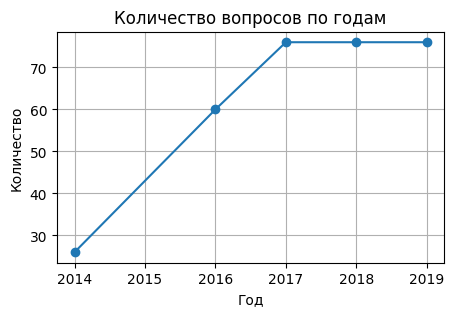

In [13]:
# Количество вопросов по годам
question_amount = '''
SELECT  a.survey_id,
		COUNT(DISTINCT(a.question_id)) AS question_amount
FROM answer a 
GROUP BY 1;
'''

cur_final.execute(question_amount)
rows = cur_final.fetchall()
question_amount = pd.DataFrame(rows, columns=('Год', 'Количество вопросов'))

plt.figure(figsize=(5, 3))
plt.plot(question_amount['Год'], question_amount['Количество вопросов'], marker='o')

# Настройка графика
plt.title('Количество вопросов по годам')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

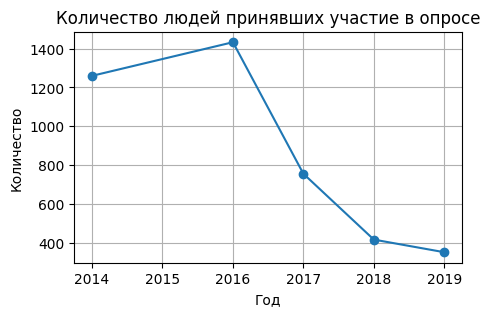

In [14]:
# Сколько людей прошло опрос в каждом году
people_amount = '''
SELECT  a.survey_id,
		COUNT(DISTINCT(a.user_id)) AS participants_amount
FROM answer a 
GROUP BY 1
'''

cur_final.execute(people_amount)
rows = cur_final.fetchall()
people_amount = pd.DataFrame(rows, columns=('Год', 'Количество людей'))

plt.figure(figsize=(5, 3))
plt.plot(people_amount['Год'], people_amount['Количество людей'], marker='o')

# Настройка графика
plt.title('Количество людей принявших участие в опросе')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

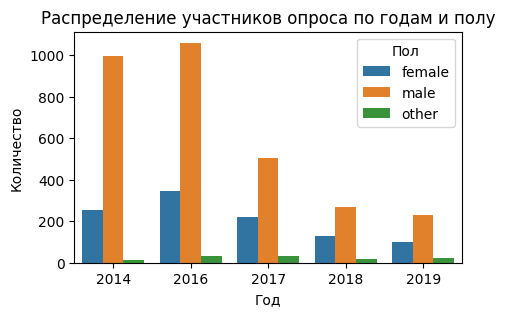

In [15]:

gender = '''
SELECT  survey_id, 
		answer_text,
		COUNT(DISTINCT(user_id)) AS amount
FROM answer
WHERE question_id = 2
GROUP BY survey_id, answer_text
ORDER BY survey_id, answer_text; 
'''

cur_final.execute(gender)
rows = cur_final.fetchall()
res = pd.DataFrame(rows, columns=('Год', 'Пол', 'Количество'))

plt.figure(figsize=(5, 3))
sns.barplot(x='Год', y='Количество', hue='Пол', data=res)
plt.title('Распределение участников опроса по годам и полу')
plt.show()


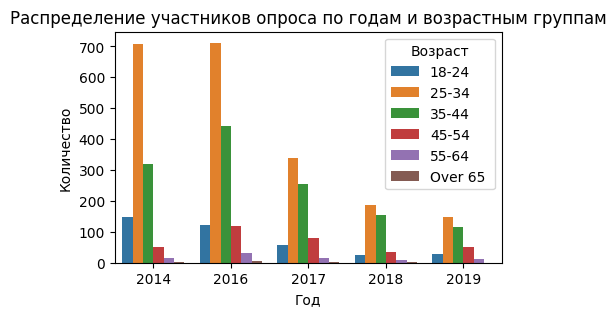

In [16]:
# Количество людей из разных возрастных групп по годам
ages = '''
SELECT a.survey_id, 
       CASE 
            WHEN a.answer_text BETWEEN 18 AND 24 THEN '18-24'
            WHEN a.answer_text BETWEEN 25 AND 34 THEN '25-34'
            WHEN a.answer_text BETWEEN 35 AND 44 THEN '35-44'
            WHEN a.answer_text BETWEEN 45 AND 54 THEN '45-54'
            WHEN a.answer_text BETWEEN 55 AND 64 THEN '55-64'
            WHEN a.answer_text BETWEEN 65 AND 99 THEN 'Over 65 '
        END AS age_group,  
    COUNT(a.user_id) AS count
FROM answer a 
WHERE a.question_id = 1 AND a.answer_text > 18   
GROUP BY a.survey_id, age_group
ORDER BY a.survey_id, age_group;  
'''

cur_final.execute(ages)
rows = cur_final.fetchall()
res = pd.DataFrame(rows, columns=('Год', 'Возраст', 'Количество'))

plt.figure(figsize=(5, 3))
sns.barplot(x='Год', y='Количество', hue='Возраст', data=res)
plt.title('Распределение участников опроса по годам и возрастным группам')
plt.show()

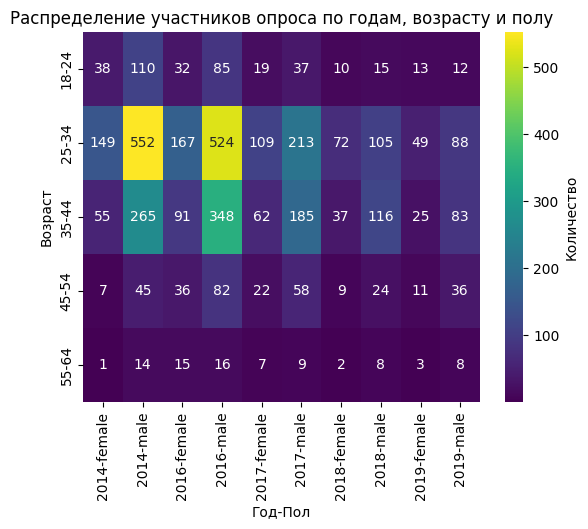

In [17]:
# Распределение участников опроса по годам, возрасту и полу
ages_gender = '''
WITH gender AS (
SELECT  a.user_id,
		a.answer_text
FROM answer a 
WHERE a.question_id = 2 AND a.answer_text != 'other'
),

age AS (
SELECT  a.survey_id,
		a.user_id,
        CASE 
            WHEN a.answer_text BETWEEN 18 AND 24 THEN '18-24'
            WHEN a.answer_text BETWEEN 25 AND 34 THEN '25-34'
            WHEN a.answer_text BETWEEN 35 AND 44 THEN '35-44'
            WHEN a.answer_text BETWEEN 45 AND 54 THEN '45-54'
            WHEN a.answer_text BETWEEN 55 AND 64 THEN '55-64'
        END AS age_group
FROM answer a 
WHERE a.question_id = 1 AND a.answer_text > 18 AND a.answer_text < 65
ORDER BY a.user_id 
)

SELECT  age.survey_id,
		age.age_group,
		gender.answer_text AS gender,
		COUNT(gender.answer_text) AS amount
FROM age
LEFT JOIN gender
ON age.user_id = gender.user_id
GROUP BY 1, 2, 3
ORDER BY 1, 2, 3;  
'''

cur_final.execute(ages_gender)
rows = cur_final.fetchall()
res = pd.DataFrame(rows, columns=('Год', 'Возраст', 'Пол', 'Количество'))

heatmap_data = res.pivot_table(index='Возраст', columns=['Год', 'Пол'], values='Количество')
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='g', cbar_kws={'label': 'Количество'})
plt.title('Распределение участников опроса по годам, возрасту и полу')
plt.show()

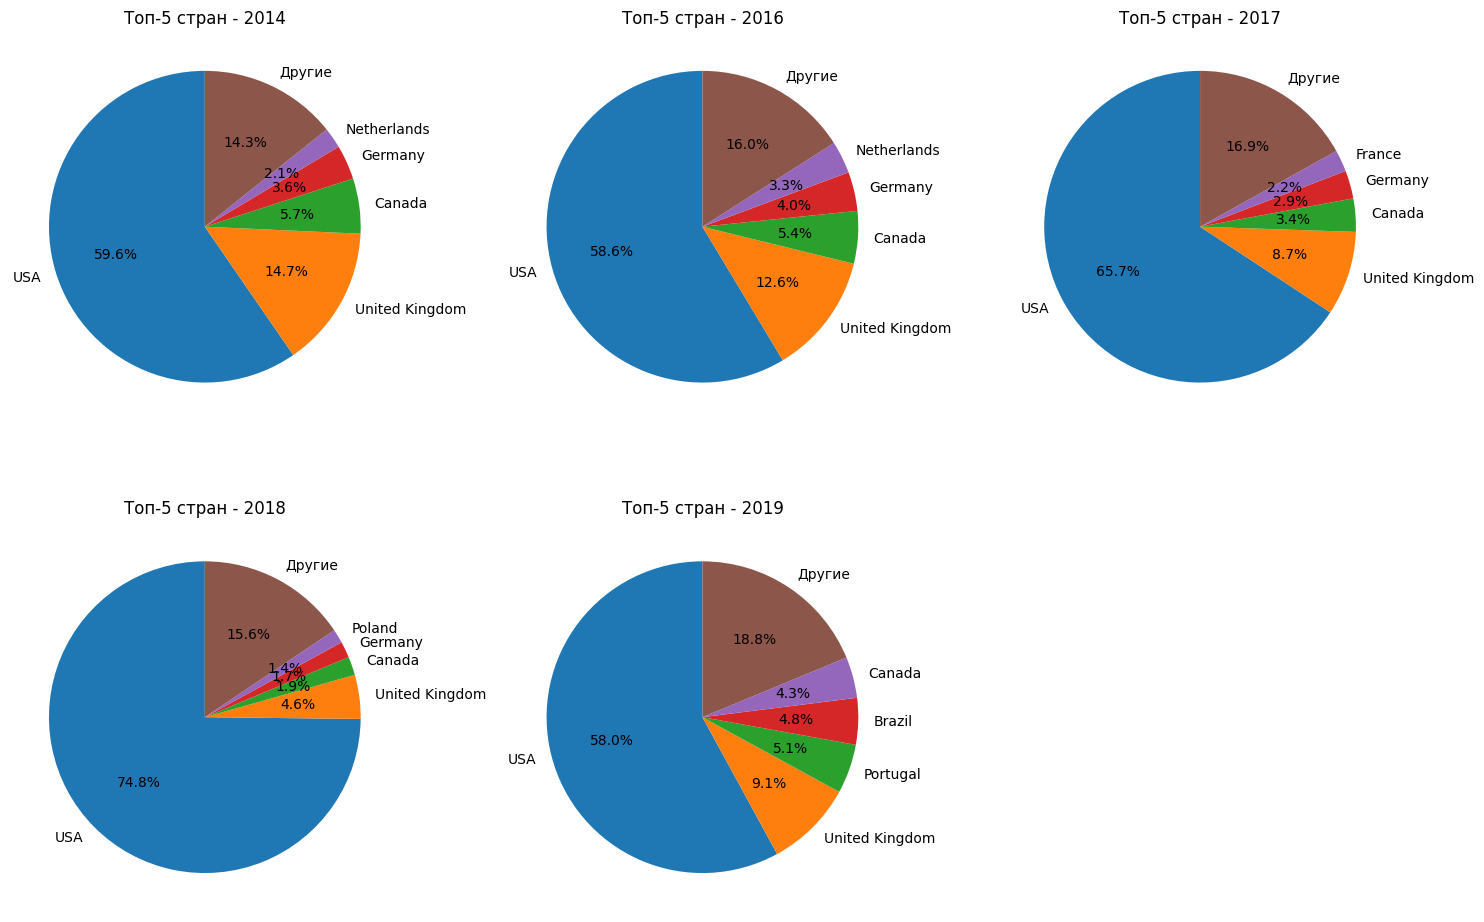

In [80]:
# Люди из каких стран принимали участие в опросе по годам
country = '''
SELECT  a.survey_id,
		a.answer_text,
		COUNT(DISTINCT(a.user_id)) AS amount
FROM answer a 
WHERE a.question_id = 3
GROUP BY a.survey_id, a.answer_text
ORDER BY a.survey_id, 3 DESC;    
'''

cur_final.execute(country)
rows = cur_final.fetchall()
res = pd.DataFrame(rows, columns=('Год', 'Страна', 'Количество'))

unique_years = res['Год'].unique()
fig = plt.figure(figsize=(15, 10))

# Итерация по уникальным годам
for i, year in enumerate(unique_years, 1):

    year_data = res[res['Год'] == year]
    
    top_countries = year_data.head(5)
    other_countries = pd.DataFrame({
        'Страна': ['Другие'],
        'Количество': [year_data['Количество'][5:].sum()]
    })

    final_data = pd.concat([top_countries, other_countries])
    
    # Постройка круговой диаграммы для текущего года
    ax = fig.add_subplot(2, 3, i)
    ax.pie(final_data['Количество'], labels=final_data['Страна'], autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Топ-5 стран - {year}')

plt.tight_layout()
plt.show()

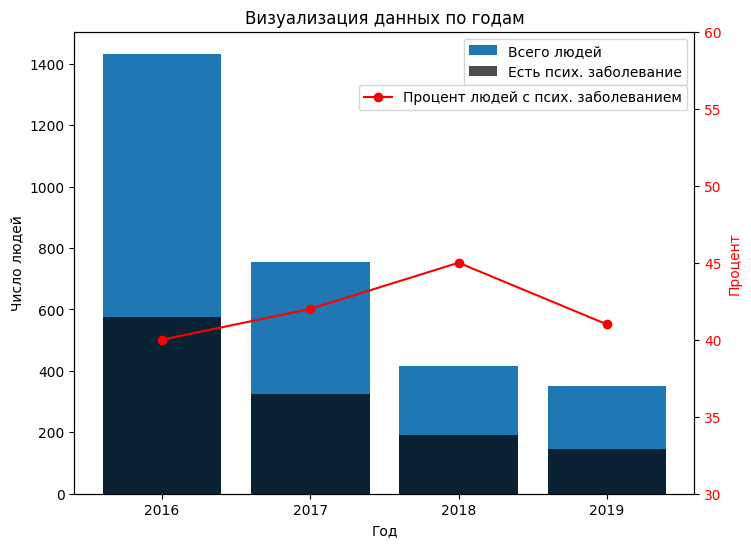

In [19]:
# Сколько процентов ответило что имеют псих заболевание 
have_disoreder = '''
WITH have_disoreder AS (
SELECT 	a.survey_id,
		a.answer_text,
		a.user_id
FROM answer a
WHERE a.question_id = 33
ORDER BY 1, 2
)

SELECT  hd.survey_id,
		COUNT(DISTINCT(hd.user_id)) AS amount_part,
		COUNT(IIF(hd.answer_text = 'Yes', 1, NULL)) AS have_disorder,
		(100 * COUNT(IIF(hd.answer_text = 'Yes', 1, NULL))) / COUNT(DISTINCT(hd.user_id)) AS percent_have_disorder
FROM have_disoreder hd
GROUP BY 1
'''

cur_final.execute(have_disoreder)
rows = cur_final.fetchall()
df = pd.DataFrame(rows, columns=('Год', 'Всего людей', 'Есть псих. заболевание', 'Процент'))

fig, ax1 = plt.subplots(figsize=(8, 6))

# Создаем гистограмму для "Всего людей" и "Имеют псих заболевание"
ax1.bar(df['Год'], df['Всего людей'], label='Всего людей')
ax1.bar(df['Год'], df['Есть псих. заболевание'], label='Есть псих. заболевание', color='black', alpha = 0.7)

ax1.set_xlabel('Год')
ax1.set_ylabel('Число людей')
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Создаем линию для "Процента"
ax2 = ax1.twinx()
ax2.plot(df['Год'], df['Процент'], color='red', marker='o', label='Процент людей с псих. заболеванием')

ax2.set_ylabel('Процент', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(30, 60)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

plt.title('Визуализация данных по годам')
plt.xticks(df['Год'])
plt.show()

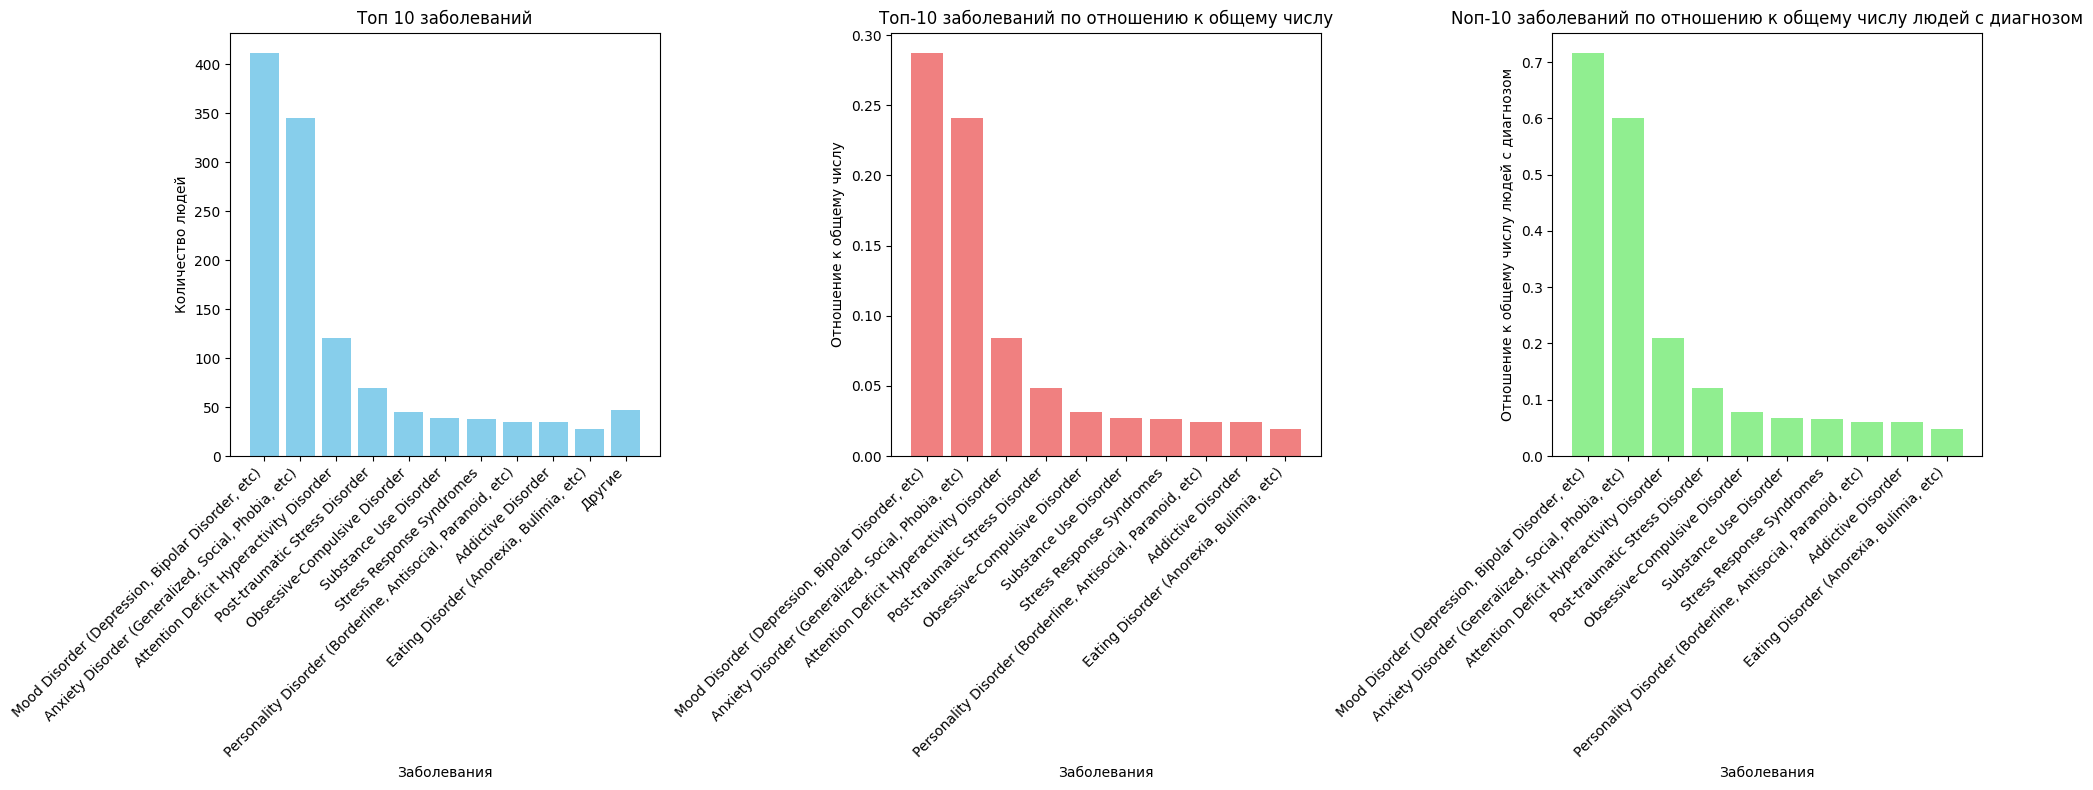

In [106]:
# Какие заболевания были у тех, кто ответил что имеют псих заболевание, 
# Какой процент от общего числа участников и от тех кто ответил что имеют псих заболевание 
# Этот вопрос только в 2016 поэтому не будет по годам
disorder = '''
WITH question115 AS (
SELECT 	a.survey_id,
		a.answer_text,
		a.user_id,
		*
FROM answer a
WHERE a.question_id = 115
ORDER BY 3 DESC
),

question33 AS (
SELECT 	a.survey_id,
		a.answer_text,
		a.user_id
FROM answer a
WHERE a.question_id = 33 AND a.answer_text = 'Yes' AND a.survey_id = 2016
ORDER BY 3 DESC
)

SELECT  q115.answer_text,
		total_amount,
		total_amount_have_disorder,
		COUNT(DISTINCT(q115.user_id)) AS amount_disorder
FROM 	question115 q115,
		(SELECT count(DISTINCT(question115.user_id)) AS total_amount FROM question115),
		(SELECT count(DISTINCT(question33.user_id)) AS total_amount_have_disorder FROM question33)
LEFT JOIN question33 q33
ON q115.user_id = q33.user_id
WHERE q33.answer_text = 'Yes'
GROUP BY 1
ORDER BY 4 DESC
'''

cur_final.execute(disorder)
rows = cur_final.fetchall()
df = pd.DataFrame(rows, columns=('Заболевание', 'Общее число', 'Общее число людей с диагнозом', 'Количество людей с этим заболеванием'))


# Столбиковая диаграмма для распределения заболеваний (Топ 10 + Другие)
top_10 = df.nlargest(10, 'Количество людей с этим заболеванием')
other = pd.DataFrame({'Заболевание': ['Другие'], 'Количество людей с этим заболеванием': [df['Количество людей с этим заболеванием'][10:].sum()]})
top_10_and_other = pd.concat([top_10, other])

fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(1, 3, 1)
plt.bar(top_10_and_other['Заболевание'], top_10_and_other['Количество людей с этим заболеванием'], color='skyblue')
plt.title('Топ 10 заболеваний')
plt.xlabel('Заболевания')
plt.ylabel('Количество людей')
plt.xticks(rotation=45, ha='right')


# Распределение топ-10 заболеваний по отношению к общему числу
df['Отношение к общему числу'] = df['Количество людей с этим заболеванием'] / df['Общее число']
top_10_ratio = df.nlargest(10, 'Отношение к общему числу')

ax = fig.add_subplot(1, 3, 2)
plt.bar(top_10_ratio['Заболевание'], top_10_ratio['Отношение к общему числу'], color='lightcoral')
plt.title('Топ-10 заболеваний по отношению к общему числу')
plt.xlabel('Заболевания')
plt.ylabel('Отношение к общему числу')
plt.xticks(rotation=45, ha='right')


# Распределение топ-10 заболеваний по отношению к общему числу людей с диагнозом
df['Отношение к общему числу людей с диагнозом'] = df['Количество людей с этим заболеванием'] / df['Общее число людей с диагнозом']
top_10_ratio_people = df.nlargest(10, 'Отношение к общему числу людей с диагнозом')

ax = fig.add_subplot(1, 3, 3)
plt.bar(top_10_ratio_people['Заболевание'], top_10_ratio_people['Отношение к общему числу людей с диагнозом'], color='lightgreen')
plt.title('Nоп-10 заболеваний по отношению к общему числу людей с диагнозом')
plt.xlabel('Заболевания')
plt.ylabel('Отношение к общему числу людей с диагнозом')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [112]:
# Кем работают те кто ответил что имеют псих заболевание, какой процент от тех кто ответил что имеют псих заболевание 

job = '''
WITH aa117 AS (
SELECT 	a.survey_id,
		a.answer_text,
		a.user_id,
		*
FROM answer a
WHERE a.question_id = 117
ORDER BY 3 DESC
),

aa33 AS (
SELECT 	a.survey_id,
		a.answer_text,
		a.user_id
FROM answer a
WHERE a.question_id = 33 AND a.answer_text = 'Yes' AND a.survey_id = 2016
ORDER BY 3 DESC
)

SELECT  aa117.answer_text,
		COUNT(DISTINCT(aa33.user_id)) AS amount_have_disorder,
		(100* COUNT(DISTINCT(aa33.user_id))) / total_amount_have_disorder AS percent_from_have_disorder
FROM 	aa117,
		(SELECT count(DISTINCT(aa33.user_id)) AS total_amount_have_disorder FROM aa33)
LEFT JOIN aa33
ON aa117.user_id = aa33.user_id
GROUP BY 1
ORDER BY 2 DESC 
'''

cur_final.execute(job)
rows = cur_final.fetchall()
df = pd.DataFrame(rows, columns=('Профессия', 'Количество людей с диагнозом', 'Процент от общего числа людей с диагнозом'))

df

,Профессия,Количество людей с диагнозом,Процент от общего числа людей с диагнозом
0,Back-end Developer,278,48
1,Front-end Developer,191,33
2,Supervisor/Team Lead,105,18
3,DevOps/SysAdmin,101,17
4,Other,76,13
5,Designer,74,12
6,One-person shop,73,12
7,Support,66,11
8,Dev Evangelist/Advocate,44,7
9,Executive Leadership,38,6


In [116]:
# 5 самых часто встречающихся заболеваний по профессиям 
jobs_with_disorders = '''
WITH q117 AS (
SELECT 	a.survey_id,
		a.answer_text,
		a.user_id
FROM answer a
WHERE a.question_id = 117 AND a.survey_id = 2016
ORDER BY 3 DESC
),

q33 AS (
SELECT 	a.survey_id,
		a.answer_text,
		a.user_id
FROM answer a
WHERE a.question_id = 33 AND a.answer_text = 'Yes' AND a.survey_id = 2016
ORDER BY 3 DESC
),

q115 AS (
SELECT 	a.survey_id,
		a.answer_text,
		a.user_id
FROM answer a
WHERE a.question_id = 115 AND a.survey_id = 2016
ORDER BY 3 DESC
),

q33_q117 AS (
SELECT  q117.answer_text,
		q33.user_id
FROM 	q117
RIGHT JOIN q33
ON q117.user_id = q33.user_id
)

SELECT *
FROM (
SELECT  q33_q117.answer_text AS job,
		q115.answer_text AS disorder,
		COUNT(q33_q117.user_id) AS amount,
		ROW_NUMBER() OVER (PARTITION BY q33_q117.answer_text ORDER BY COUNT(q33_q117.user_id) DESC) AS rating
FROM q33_q117
LEFT JOIN q115
ON q33_q117.user_id = q115.user_id
GROUP BY 1, 2
ORDER BY 1, 3 DESC) AS res
WHERE res.rating <= 5
'''

cur_final.execute(jobs_with_disorders)
rows = cur_final.fetchall()
df = pd.DataFrame(rows, columns=('Профессия', 'Заболевание', 'Количество', 'Рейтинг'))

df

,Профессия,Заболевание,Количество,Рейтинг
0,Back-end Developer,"Mood Disorder (Depression, Bipolar Disorder, etc)",195,1
1,Back-end Developer,"Anxiety Disorder (Generalized, Social, Phobia,...",168,2
2,Back-end Developer,Attention Deficit Hyperactivity Disorder,61,3
3,Back-end Developer,Post-traumatic Stress Disorder,30,4
4,Back-end Developer,Substance Use Disorder,17,5
5,Designer,"Mood Disorder (Depression, Bipolar Disorder, etc)",54,1
6,Designer,"Anxiety Disorder (Generalized, Social, Phobia,...",43,2
7,Designer,Attention Deficit Hyperactivity Disorder,21,3
8,Designer,Post-traumatic Stress Disorder,10,4
9,Designer,Substance Use Disorder,8,5
